Mount your google drive !!




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Brain Tumor Detection Using a Convolutional Neural Network(CNN)**
---
**About the Brain MRI Images dataset:** 
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous


**Import Necessary Modules**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import pandas as pd
%matplotlib inline

**Data Preparation & Preprocessing**
---
In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain.



In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

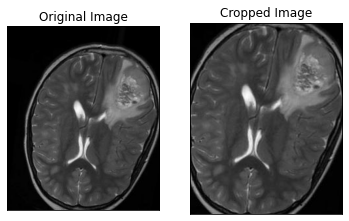

In [3]:
ex_img = cv2.imread('/content/drive/My Drive/augmented data/yes/aug_Y100_0_4855.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

**Load up the data:**
---
The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

1)Read the image.
---
2)Crop the part of the image representing only the brain.
---
3)Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
---
4)Apply normalization because we want pixel values to be scaled to the range 0-1.
---
5)Append the image to X and its label to y.
---
After that, Shuffle X and y it's Return X and y.

In [56]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

**Loaction of our Data**

In [57]:


augmented_yes = '/content/drive/My Drive/augmented data/yes'
augmented_no = '/content/drive/My Drive/augmented data/no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


**Plot sample images:**

In [7]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

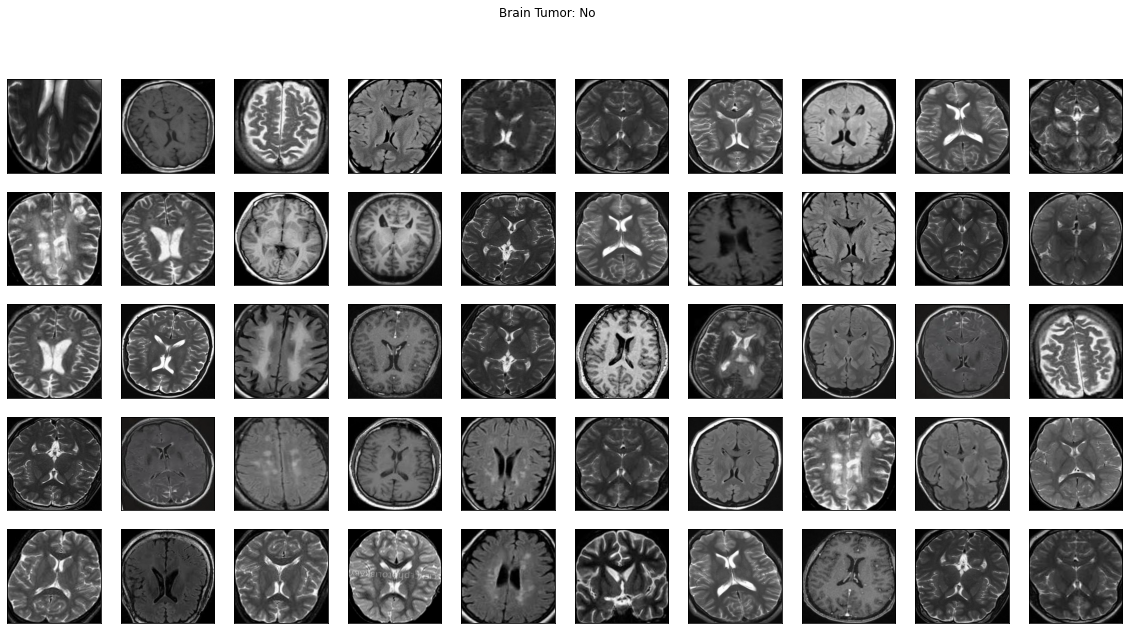

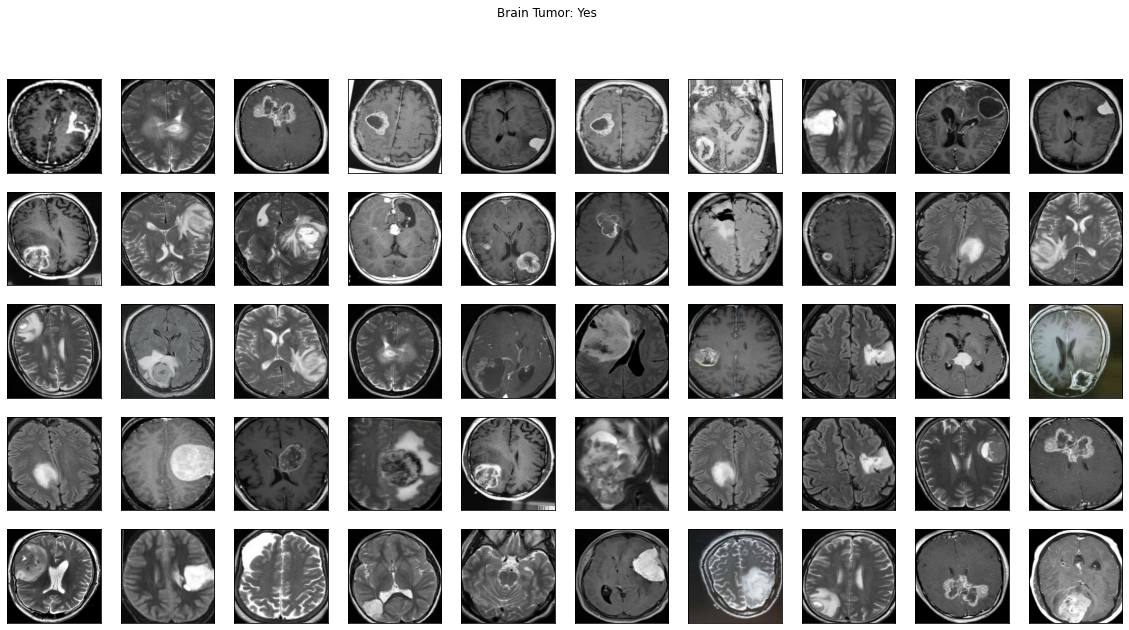

In [8]:
plot_sample_images(X, y)

**Split the data:**
---
Split X and y into training, validation and validation sets.

In [10]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:
---
1)70% of the data for training.
---
2)15% of the data for validation.
---
3)15% of the data for testing.
---



In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of Validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val  shape: " + str(X_val.shape))
print ("Y_val  shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of Validation examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val  shape: (310, 240, 240, 3)
Y_val  shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


**Build the model**
---
Let's build a convolutional neural network model: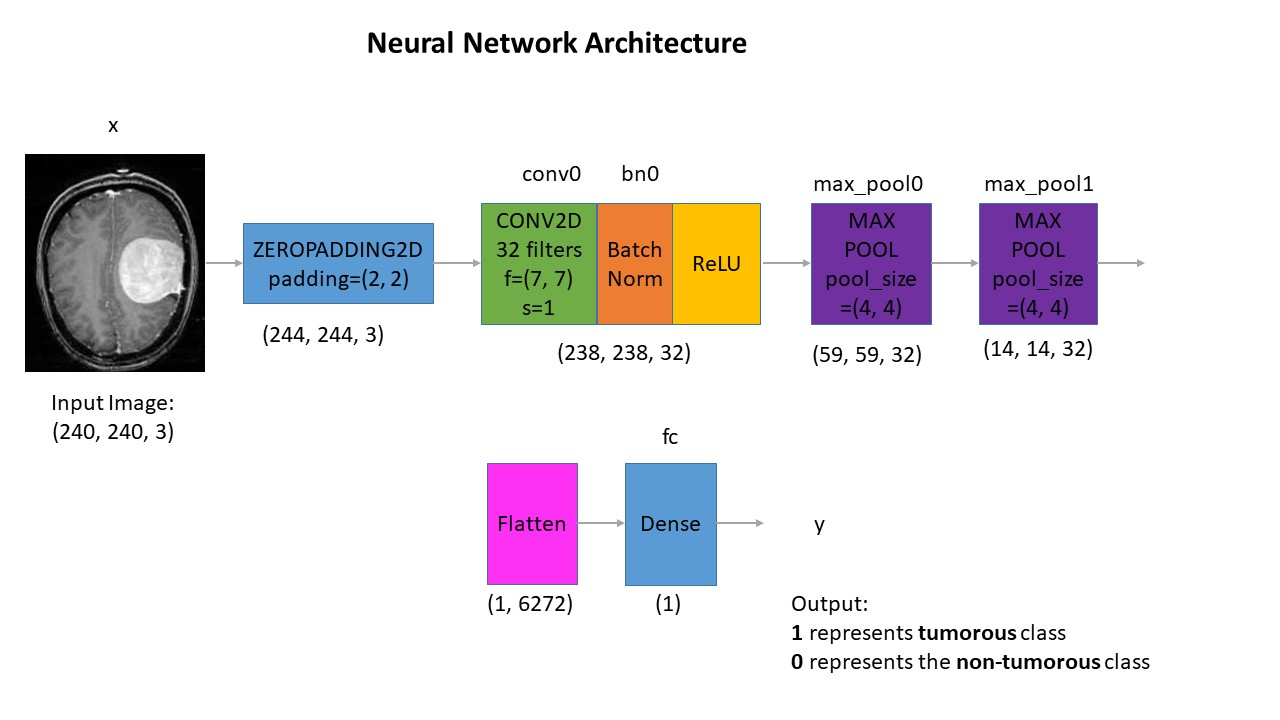

In [15]:
def build_model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [16]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [17]:
model = build_model(IMG_SHAPE)

In [18]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

Compile the model:

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Model.h5",save_best_only=True)

**Train the model**

In [22]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[checkpoint_cb])
print("model train sucessfully")

Epoch 1/10
46/46 [==============================] - 120s 3s/step - loss: 0.8549 - accuracy: 0.6187 - val_loss: 0.6637 - val_accuracy: 0.5613
Epoch 2/10
46/46 [==============================] - 119s 3s/step - loss: 0.5409 - accuracy: 0.7439 - val_loss: 0.6034 - val_accuracy: 0.6774
Epoch 3/10
46/46 [==============================] - 119s 3s/step - loss: 0.4194 - accuracy: 0.8118 - val_loss: 0.5433 - val_accuracy: 0.7968
Epoch 4/10
46/46 [==============================] - 119s 3s/step - loss: 0.4093 - accuracy: 0.8000 - val_loss: 0.5276 - val_accuracy: 0.7516
Epoch 5/10
46/46 [==============================] - 120s 3s/step - loss: 0.3750 - accuracy: 0.8304 - val_loss: 0.7610 - val_accuracy: 0.5484
Epoch 6/10
46/46 [==============================] - 119s 3s/step - loss: 0.3647 - accuracy: 0.8304 - val_loss: 0.6879 - val_accuracy: 0.6000
Epoch 7/10
46/46 [==============================] - 119s 3s/step - loss: 0.3258 - accuracy: 0.8616 - val_loss: 0.5063 - val_accuracy: 0.7387
Epoch 8/10
46

Our model is still not converge, train it for some more epoch

In [23]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=15, validation_data=(X_val, y_val), callbacks=[checkpoint_cb])
print("model train sucessfully")

Epoch 1/15
46/46 [==============================] - 120s 3s/step - loss: 0.2197 - accuracy: 0.9176 - val_loss: 0.3823 - val_accuracy: 0.8258
Epoch 2/15
46/46 [==============================] - 120s 3s/step - loss: 0.1985 - accuracy: 0.9280 - val_loss: 0.3901 - val_accuracy: 0.8516
Epoch 3/15
46/46 [==============================] - 119s 3s/step - loss: 0.1959 - accuracy: 0.9273 - val_loss: 0.3845 - val_accuracy: 0.8452
Epoch 4/15
46/46 [==============================] - 119s 3s/step - loss: 0.2535 - accuracy: 0.8955 - val_loss: 0.3818 - val_accuracy: 0.8290
Epoch 5/15
46/46 [==============================] - 119s 3s/step - loss: 0.1786 - accuracy: 0.9322 - val_loss: 0.4172 - val_accuracy: 0.8290
Epoch 6/15
46/46 [==============================] - 120s 3s/step - loss: 0.1599 - accuracy: 0.9419 - val_loss: 0.3591 - val_accuracy: 0.8677
Epoch 7/15
46/46 [==============================] - 119s 3s/step - loss: 0.1431 - accuracy: 0.9481 - val_loss: 0.3533 - val_accuracy: 0.8613
Epoch 8/15
46

In [24]:
history = model.history.history

In [27]:

for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


**Plot Loss & Accuracy**

In [42]:

def plot_metrics(history):
    pd.DataFrame(history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
  


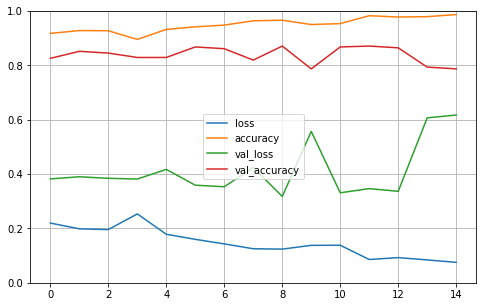

In [43]:
plot_metrics(history)


**RESULTS**

---
Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 22nd iteration with validation accuracy of **87%**

**Load the best model**

In [45]:
best_model = tf.keras.models.load_model('/content/Model.h5') 

In [46]:
best_model.metrics_names

['loss', 'accuracy']

In [47]:
loss, accuracy = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 6s 603ms/step - loss: 0.3270 - accuracy: 0.8710


**Accuracy of the best model on the testing data:**

In [48]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {accuracy}")

Test Loss = 0.32701486349105835
Test Accuracy = 0.8709677457809448


**F1 score for the best model on the testing data:**

In [50]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [51]:
y_test_prob = best_model.predict(X_test)

In [53]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8734177215189874


Let's also find the f1 score on the validation data:

In [54]:
y_val_prob = best_model.predict(X_val)

In [55]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8717948717948718


**Conclusion:**
---
**Now, the model detects brain tumor with:**
---
**87.1**%  accuracy on the test set.
---
**0.87** f1 score on the test set.
---
These resutls are very good considering that the data is balanced.